In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.metrics import RootMeanSquaredError, MeanAbsoluteError

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit


import warnings
warnings.filterwarnings('ignore')

In [ ]:
end = '2019-12-31'
start = '1999-01-02'

trainingData = yf.download('AMD', start=start, end=end)
trainingData.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
1999-01-04,14.50000,14.75000,13.81250,14.00000,14.00000,4987600
1999-01-05,13.96875,14.28125,13.50000,13.84375,13.84375,10463200
1999-01-06,14.06250,14.18750,13.56250,13.62500,13.62500,12031200
1999-01-07,13.50000,14.15625,13.43750,13.71875,13.71875,9706000
1999-01-08,14.25000,14.31250,13.84375,14.00000,14.00000,6955800


In [ ]:
end = '2024-03-28'
start = '2020-01-02'

testingData = yf.download('AMD', start=start, end=end)
testingData


[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,46.860001,49.250000,46.630001,49.099998,49.099998,80331100
2020-01-03,48.029999,49.389999,47.540001,48.599998,48.599998,73127400
2020-01-06,48.020000,48.860001,47.860001,48.389999,48.389999,47934900
2020-01-07,49.349998,49.389999,48.040001,48.250000,48.250000,58061400
2020-01-08,47.849998,48.299999,47.139999,47.830002,47.830002,53767000
...,...,...,...,...,...,...
2024-03-21,185.970001,187.690002,177.660004,178.679993,178.679993,75265600
2024-03-22,177.210007,180.759995,175.050003,179.649994,179.649994,57832100
2024-03-25,172.899994,182.800003,172.000000,178.630005,178.630005,71935300


In [ ]:
trainprice = trainingData['Adj Close']
trainData = trainprice.values

testprice = testingData['Adj Close']
testData = testprice.values

In [ ]:
trainData


array([14.        , 13.84375   , 13.625     , ..., 46.63000107,
       46.18000031, 45.52000046])

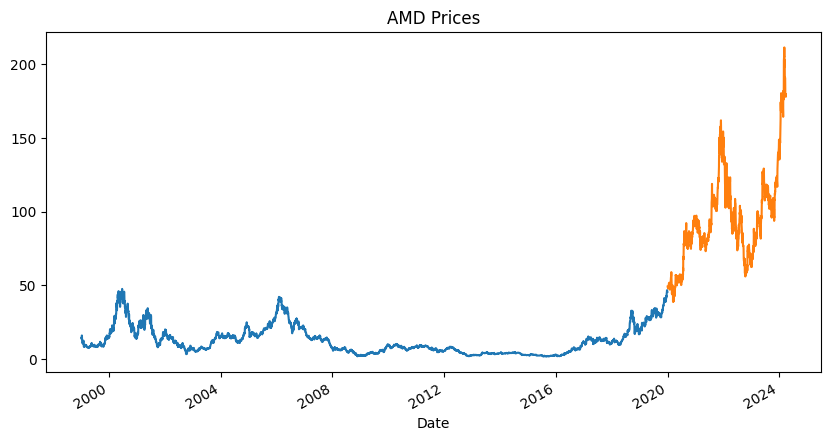

In [ ]:
trainingData['Adj Close'].plot(figsize=(10,5), title = "AMD Prices")
testingData['Adj Close'].plot(figsize=(10,5), title = "AMD Prices")

plt.show()

In [ ]:
sc = MinMaxScaler(feature_range=(0,1))
trainDataScaled = sc.fit_transform(trainData.reshape(-1, 1))
testDataScaled = sc.fit_transform(testData.reshape(-1, 1))

In [ ]:
n_steps = 20

xTrain, yTrain = [], []

for i in range(n_steps, len(trainDataScaled)):
    xTrain.append(trainDataScaled[i-n_steps:i, 0])
    yTrain.append(trainDataScaled[i, 0])

xTrain, yTrain = np.array(xTrain), np.array(yTrain)
xTrain = np.reshape(xTrain, (xTrain.shape[0], xTrain.shape[1], 1))


In [ ]:
#LSTM Model
from tensorflow.keras.optimizers import Adam
model = Sequential()

#Layer 1
model.add(LSTM(units=200,return_sequences=True,input_shape=(xTrain.shape[1], 1)))
model.add(Dropout(0.2))
#Layer 2
model.add(LSTM(units=200,return_sequences=True))
model.add(Dropout(0.2))
#Layer 3
model.add(LSTM(units=200,return_sequences=True))
model.add(Dropout(0.2))
#Layer 4
model.add(LSTM(units=200, return_sequences=False))
model.add(Dropout(0.2))
#Layer 5
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error', metrics=[RootMeanSquaredError(), MeanAbsoluteError()])
model.summary()

#Early stopping parameters to stop unnecessary training
earlyStopping = EarlyStopping(
    monitor='val_root_mean_squared_error',
    patience=15,
    mode='min',
    min_delta = 0.000001
)


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_56 (LSTM)              (None, 20, 200)           161600    
                                                                 
 dropout_56 (Dropout)        (None, 20, 200)           0         
                                                                 
 lstm_57 (LSTM)              (None, 20, 200)           320800    
                                                                 
 dropout_57 (Dropout)        (None, 20, 200)           0         
                                                                 
 lstm_58 (LSTM)              (None, 20, 200)           320800    
                                                                 
 dropout_58 (Dropout)        (None, 20, 200)           0         
                                                                 
 lstm_59 (LSTM)              (None, 200)             

In [ ]:
def plot_metric(history, metric):
    train_metrics = history.history[metric]
    val_metrics = history.history['val_'+metric]
    epochs = range(1, len(train_metrics) + 1)
    plt.plot(epochs, train_metrics)
    plt.plot(epochs, val_metrics)
    plt.title('Training and validation '+ metric)
    plt.xlabel("Epochs")
    plt.ylabel(metric)
    plt.legend(["train_"+metric, 'val_'+metric])
    plt.show()

In [ ]:
#Evaluation of model to confirm if parameters set above are valid
eval = model.evaluate(xTrain, yTrain)

165/165 [==============================] - 20s 96ms/step - loss: 0.0986 - root_mean_squared_error: 0.3139 - mean_absolute_error: 0.2357


In [ ]:
len(xTrain)

5262

Epoch 1/100
31/31 [==============================] - 27s 616ms/step - loss: 0.0551 - root_mean_squared_error: 0.2348 - mean_absolute_error: 0.1687 - val_loss: 0.0596 - val_root_mean_squared_error: 0.2441 - val_mean_absolute_error: 0.1752
Epoch 2/100
31/31 [==============================] - 18s 601ms/step - loss: 0.0229 - root_mean_squared_error: 0.1515 - mean_absolute_error: 0.0817 - val_loss: 0.0440 - val_root_mean_squared_error: 0.2097 - val_mean_absolute_error: 0.1485
Epoch 3/100
31/31 [==============================] - 19s 614ms/step - loss: 0.0207 - root_mean_squared_error: 0.1439 - mean_absolute_error: 0.1026 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1565 - val_mean_absolute_error: 0.1165
Epoch 4/100
31/31 [==============================] - 20s 644ms/step - loss: 0.0121 - root_mean_squared_error: 0.1101 - mean_absolute_error: 0.0767 - val_loss: 0.0471 - val_root_mean_squared_error: 0.2171 - val_mean_absolute_error: 0.1585
Epoch 5/100
31/31 [=============================

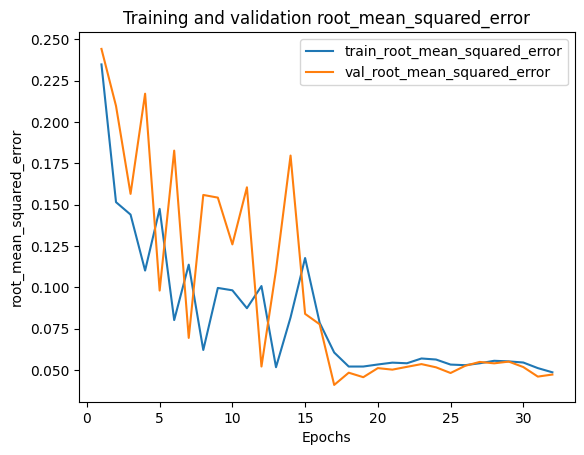

In [ ]:
log = model.fit(
    xTrain,
    yTrain,
    epochs=100,
    batch_size=128,
    validation_split = 0.25,
    verbose=1,
    callbacks=[earlyStopping],
    shuffle=False)
plot_metric(log, 'root_mean_squared_error')

In [ ]:
n_steps = 20

xTest = []
yTest = []

for i in range(n_steps, len(testDataScaled)):
    xTest.append(testDataScaled[i-n_steps:i, 0])
    yTest.append(testDataScaled[i, 0])
xTest, yTest = np.array(xTest), np.array(yTest)
xTest = np.reshape(xTest, (xTest.shape[0], xTest.shape[1], 1))



In [ ]:
predictions = model.predict(xTest) #Prediction on Data using trained model
output = sc.inverse_transform(predictions)
rmse = np.sqrt(mean_squared_error(predictions, yTest)) #Calculating of RMSE
rmse

33/33 [==============================] - 4s 65ms/step


0.06425156982711211

In [ ]:
eval = model.evaluate(xTest, yTest) #Calculating of additional metrics (Loss, RMSE, MAE)

33/33 [==============================] - 2s 69ms/step - loss: 0.0041 - root_mean_squared_error: 0.0643 - mean_absolute_error: 0.0527


In [ ]:
df1 = pd.DataFrame(testingData['Adj Close']).astype(float)
df1 = df1.iloc[:-20]
df1 = df1.reset_index(drop=False)


df2 = pd.DataFrame(output, columns = ['Pred Adj Close']).astype(float)


In [ ]:
df2

,Pred Adj Close
0,52.474529
1,52.272942
2,51.970661
3,51.657322
4,51.409981
...,...
1041,201.510010
1042,199.870422
1043,198.120667
1044,196.370636


In [ ]:
df = df1.join(df2)
df = df.set_index('Date')

In [ ]:
df

,Adj Close,Pred Adj Close
Date,,
2020-01-02,49.099998,52.474529
2020-01-03,48.599998,52.272942
2020-01-06,48.389999,51.970661
2020-01-07,48.250000,51.657322
2020-01-08,47.830002,51.409981
...,...,...
2024-02-22,181.860001,201.510010
2024-02-23,176.520004,199.870422
2024-02-26,176.009995,198.120667


Results

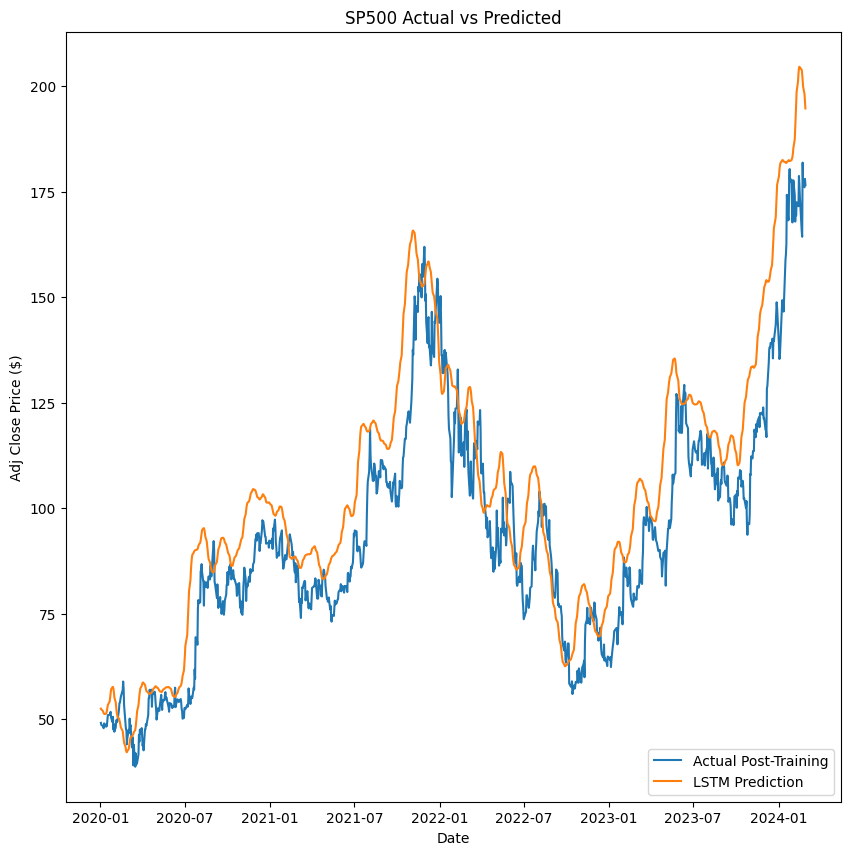

In [ ]:
real = df['Adj Close']
pred = df['Pred Adj Close']
plt.figure(figsize=(10,10))
plt.title('SP500 Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Adj Close Price ($)')
plt.plot(real)
plt.plot(pred)
plt.legend(['Actual Post-Training','LSTM Prediction'], loc='lower right')
plt.xticks()
plt.show()

In [ ]:
import numpy as np
import pandas as pd

last_sequence = testDataScaled[-n_steps:].reshape(1, n_steps, 1)
future_predictions = []
for _ in range(30):
    next_day_pred = model.predict(last_sequence)
    future_predictions.append(next_day_pred.flatten()[0])
    last_sequence = np.append(last_sequence[:, 1:, :], np.expand_dims(next_day_pred, axis=1), axis=1)

future_predictions = np.array(future_predictions).reshape(-1, 1)
future_predictions = sc.inverse_transform(future_predictions)

last_date = testingData.index.max()
# Using bdate_range to ensure only business days are included
predicted_dates = pd.bdate_range(start=last_date + pd.Timedelta(days=1), periods=30, freq='B')

predicted_df = pd.DataFrame(future_predictions, index=predicted_dates, columns=['Predicted Adj Close'])
print(predicted_df)

1/1 [==============================] - 0s 44ms/step
            Predicted Adj Close
2024-03-28           193.205505
2024-03-29           192.172455
2024-04-01           191.719345
2024-04-02           191.796539
2024-04-03           192.265991
2024-04-04           192.970490
2024-04-05           193.797775
2024-04-08           194.672150
2024-04-09           195.550537
2024-04-10           196.391479
2024-04-11           197.205322
2024-04-12           197.989014
2024-04-15           198.730026
2024-04-16           199.440536
2024-04-17           200.133987
2024-04-18           200.800598
2024-04-19           201.441986
2024-04-22           202.057602
2024-04-23           202.651611
2024-04-24           203.224182
2024-04-25           203.773239
2024-04-26           204.286575
2024-04-29           204.786209
2024-04-30           205.269440
2024-05-01           205.734695
2024-05-02           206.181656
2024-05-03           206.610336
2024-05-06           207.021088
2024-05-07          

In [ ]:
predicted_df

,Predicted Adj Close
2024-03-28,193.205505
2024-03-29,192.172455
2024-04-01,191.719345
2024-04-02,191.796539
2024-04-03,192.265991
2024-04-04,192.970490
2024-04-05,193.797775
2024-04-08,194.672150
2024-04-09,195.550537
2024-04-10,196.391479


In [ ]:
train_predictions = model.predict(xTrain)
train_predictions = sc.inverse_transform(train_predictions)  # Rescale to the original scale

165/165 [==============================] - 14s 82ms/step


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.title('AMD Training Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price ($)')

adjusted_dates = trainingData.index[n_steps:]

plt.plot(adjusted_dates, trainData[n_steps:], label='Actual Training Data', color='blue')
plt.plot(adjusted_dates, train_predictions.flatten(), label='Predicted Training Data', color='orange')

plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()